<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/No_Search_MMM_pymc_Dec2024_spend_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc_marketing

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [5]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})

In [6]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales], axis=1).fillna(0).head(144)

In [7]:
df

,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Impressions,GoogleAds_NonBranded_Spend,Programatic_Spend,Programatic_Impressions,FTF_Spend,FTF_Impressions,contacts,Revenue
Date,,,,,,,,,,,,,,,,,,,,
2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.00,0.0,147.0,86.760000,1365.0,196.730000,0.00,0.0,0.0,0.0,0.0,44191.70
2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.00,0.0,806.0,496.890000,7085.0,1300.330000,0.00,0.0,3036.0,6487.0,561.0,99989.50
2022-01-16,11.0,7.87,5217.0,823.99,0.0,0.0,0.0,0.0,0.00,0.0,866.0,265.980000,6520.0,1251.740000,0.00,0.0,7176.0,10886.0,914.0,147772.39
2022-01-23,31.0,20.69,9084.0,834.35,0.0,0.0,111374.0,1000.0,0.00,0.0,908.0,146.240000,5910.0,911.130000,0.00,0.0,1656.0,1378.0,99.0,134056.43
2022-01-30,19.0,22.09,11871.0,835.66,0.0,0.0,0.0,0.0,0.00,0.0,722.0,154.490000,6567.0,1181.790000,0.00,0.0,4140.0,3511.0,507.0,229189.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,137.0,223.57,768.0,493.42,0.0,0.0,0.0,0.0,1284.14,373499.0,786.0,704.878583,4048.0,1500.009348,840.42,243539.0,0.0,0.0,0.0,156221.84
2024-09-08,174.0,245.35,424.0,410.70,0.0,0.0,0.0,0.0,1282.05,389795.0,816.0,801.801360,4090.0,1334.002493,829.75,282064.0,0.0,0.0,0.0,199752.84
2024-09-15,208.0,224.73,362.0,434.44,0.0,0.0,0.0,0.0,1284.53,364030.0,836.0,522.223274,4093.0,1083.907463,822.62,274108.0,0.0,0.0,0.0,162318.56


In [8]:
input_df = df[['Revenue', *[c for c in df.columns if 'Impressions' in c]]]
spend_df = df[['Revenue', *[c for c in df.columns if 'Spend' in c]]]

In [9]:
input_df

,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions
Date,,,,,,,,,,
2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,0.0
2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,6487.0
2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,10886.0
2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,1378.0
2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,3511.0
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,0.0
2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,0.0
2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,0.0


In [10]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

#df = spend_df.copy()  #change this to run for spend vs impressions
df = input_df.copy()
df = df.reset_index()

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [11]:
df

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions,year,month,dayofyear
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,0.0,2022,1,2
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,6487.0,2022,1,9
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,10886.0,2022,1,16
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,1378.0,2022,1,23
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,3511.0,2022,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,0.0,2024,9,245
140,2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,0.0,2024,9,252
141,2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,0.0,2024,9,259
142,2024-09-22,163221.03,72.0,35.0,0.0,0.0,373172.0,816.0,3778.0,139614.0,0.0,2024,9,266


In [12]:
df["gt_2023"] = (df["Date"] == "2023-11-26").astype(float)
df["gt_2022"] = (df["Date"] == "2022-11-29").astype(float)
df["eoy_2023"] = (df["Date"] == "2023-12-31").astype(float)
df["eoy_2022"] = (df["Date"] == "2022-12-31").astype(float)
df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
df["end_of_year"] = (df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)


In [13]:
df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

In [14]:
# trend feature
data = df.copy()

#data["t"] = range(n)

data.head()

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,...,year,month,dayofyear,gt_2023,gt_2022,eoy_2023,eoy_2022,eoy_campaign,end_of_year,trend
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,...,2022,1,2,0.0,0.0,0.0,0.0,0,False,44191.70
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,...,2022,1,9,0.0,0.0,0.0,0.0,0,False,44191.70
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,...,2022,1,16,0.0,0.0,0.0,0.0,0,False,99989.50
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,...,2022,1,23,0.0,0.0,0.0,0.0,0,False,147772.39
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,...,2022,1,30,0.0,0.0,0.0,0.0,0,False,134056.43


In [15]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [16]:
spend_df[[   'DM_Spend',
       'Email_Spend', 'FB_Spend',
        'Programatic_Spend','FTF_Spend']].sum(axis=0)

#removed branded search

,0
DM_Spend,1596722.00
Email_Spend,46000.00
FB_Spend,24327.22
Programatic_Spend,35370.12
FTF_Spend,230558.00


In [17]:
input_df[[   'DM_Impressions',
       'Email_Impressions', 'FB_Impressions',
        'Programatic_Impressions','FTF_Impressions']].sum(axis=0)

,0
DM_Impressions,2089808.0
Email_Impressions,4401968.0
FB_Impressions,3061127.0
Programatic_Impressions,7659514.0
FTF_Impressions,182097.0


In [18]:
total_spend_per_channel = spend_df[[  'DM_Spend',
       'Email_Spend', 'FB_Spend',
        'Programatic_Spend','FTF_Spend']].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

,0
DM_Spend,0.826043
Email_Spend,0.023797
FB_Spend,0.012585
Programatic_Spend,0.018298
FTF_Spend,0.119276


In [19]:
total_impressions_per_channel = input_df[[   'DM_Impressions',
       'Email_Impressions', 'FB_Impressions',
        'Programatic_Impressions','FTF_Impressions']].sum(axis=0)

impressions_share = total_impressions_per_channel / total_impressions_per_channel.sum()

impressions_share

,0
DM_Impressions,0.120142
Email_Impressions,0.253066
FB_Impressions,0.175982
Programatic_Impressions,0.440341
FTF_Impressions,0.010469


In [20]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [21]:
input_df.columns

Index(['Revenue', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions'],
      dtype='object')

In [22]:
n_channels = 5

prior_sigma = n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[4.1302139630876376,
 0.11898742692969179,
 0.0629268111337508,
 0.09149129497813978,
 0.5963805038707801]

In [23]:
n_channels = 5

prior_sigma = n_channels * impressions_share.to_numpy()

prior_sigma.tolist()

[0.6007089361622866,
 1.2653322766016917,
 0.879911620410895,
 2.20170393952944,
 0.05234322729568645]

In [24]:
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [25]:
X.gt_2023.unique()

array([0., 1.])

In [26]:
#retrieves the default configuration from pymc

dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [65]:



my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 50, "sigma": 10}},
   "alpha": {
    "dist": "Beta",
    "kwargs": {
        "alpha": [6, 5, 3, 3, 7],  # DM, Email, FB, Programmatic, FTF
        "beta": [2, 2, 2, 2, 2],   # DM, Email, FB, Programmatic, FTF
    },
},

    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": [0.5, 1.0, 0.5, 0.7, 1.0]},
    },
    "gamma_control": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 0.5}},
    "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}},
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 5}},
        },
    },
}




In [72]:
my_model_config = {

    "intercept": {"dist": "Normal", "kwargs": {"mu": 50, "sigma": 10}},



    #"saturation_beta": {
    #    "dist": "HalfNormal",
    #    "kwargs": {"sigma": prior_sigma},
    #},

   "saturation_beta": {"dist": "HalfNormal", "kwargs": {"sigma": 3}},

   "alpha": {"dist": "Beta", "kwargs": {"alpha": 2, "beta": 2}},  # Adstock decay
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {"mu": 10, "sigma": 3 },
    },
    #"gamma_fourier": {
    #    "dist": "Laplace",
    #    "kwargs": {"mu": 0, "b": 0.2},
    #},
    "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}},

    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}

In [73]:
my_sampler_config = {"progressbar": True}

In [74]:
print(my_model_config)

{'intercept': {'dist': 'Normal', 'kwargs': {'mu': 50, 'sigma': 10}}, 'saturation_beta': {'dist': 'HalfNormal', 'kwargs': {'sigma': 3}}, 'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 2, 'beta': 2}}, 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 10, 'sigma': 3}}, 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'mu': 0, 'b': 1}}, 'likelihood': {'dist': 'Normal', 'kwargs': {'sigma': {'dist': 'Exponential', 'kwargs': {'lam': 0.1}}}}}


In [84]:
# Build the MMM model


mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=16),    saturation=LogisticSaturation(),  # Can remain common for simplicity
    channel_columns=['DM_Impressions', 'Email_Impressions', 'FB_Impressions', 'Programatic_Impressions', "FTF_Impressions"],
    control_columns=[
        'end_of_year', 'eoy_campaign', 'trend'
    ],
    yearly_seasonality=1,
)

In [79]:
data.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions', 'year', 'month', 'dayofyear', 'gt_2023', 'gt_2022',
       'eoy_2023', 'eoy_2022', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [85]:
print(mmm.default_model_config)


{'intercept': Prior("Normal", mu=0, sigma=2), 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)), 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"), 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"), 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"), 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"), 'saturation_beta': Prior("HalfNormal", sigma=3, dims="channel")}


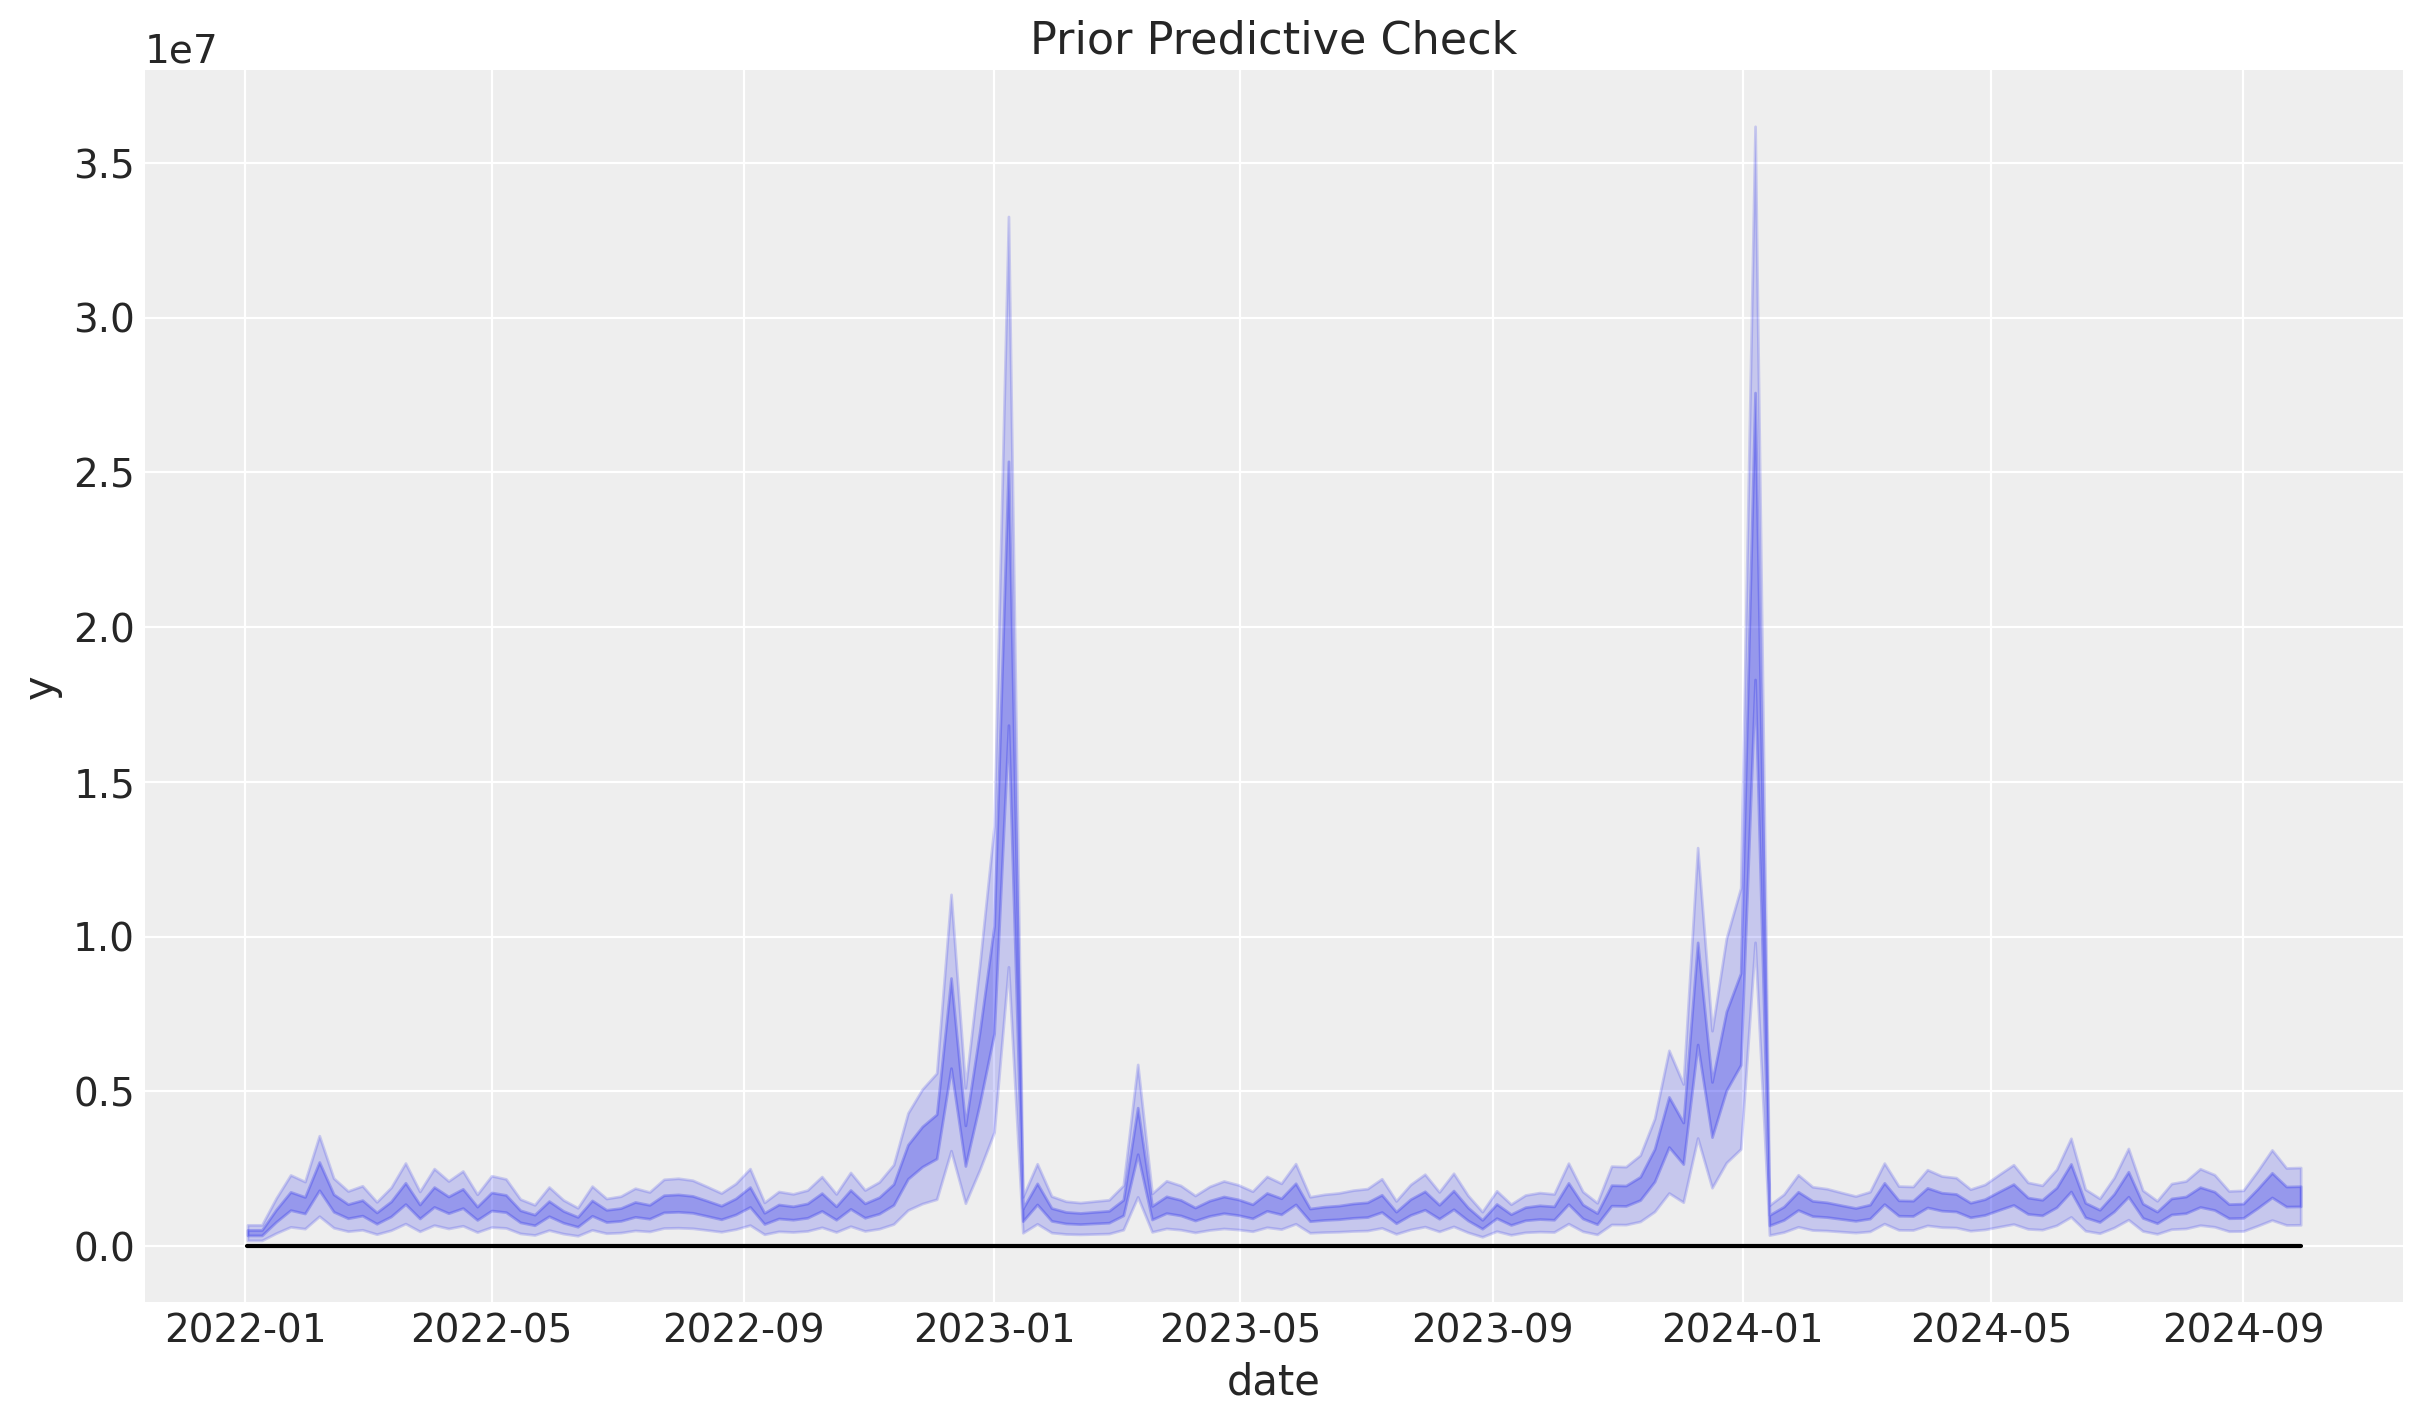

In [86]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)
#mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

mmm.plot_prior_predictive();

In [83]:
mmm.plot_components_contributions(component="seasonality")


RuntimeError: The model hasn't been fit yet, call .fit() first

In [87]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [88]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Output()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

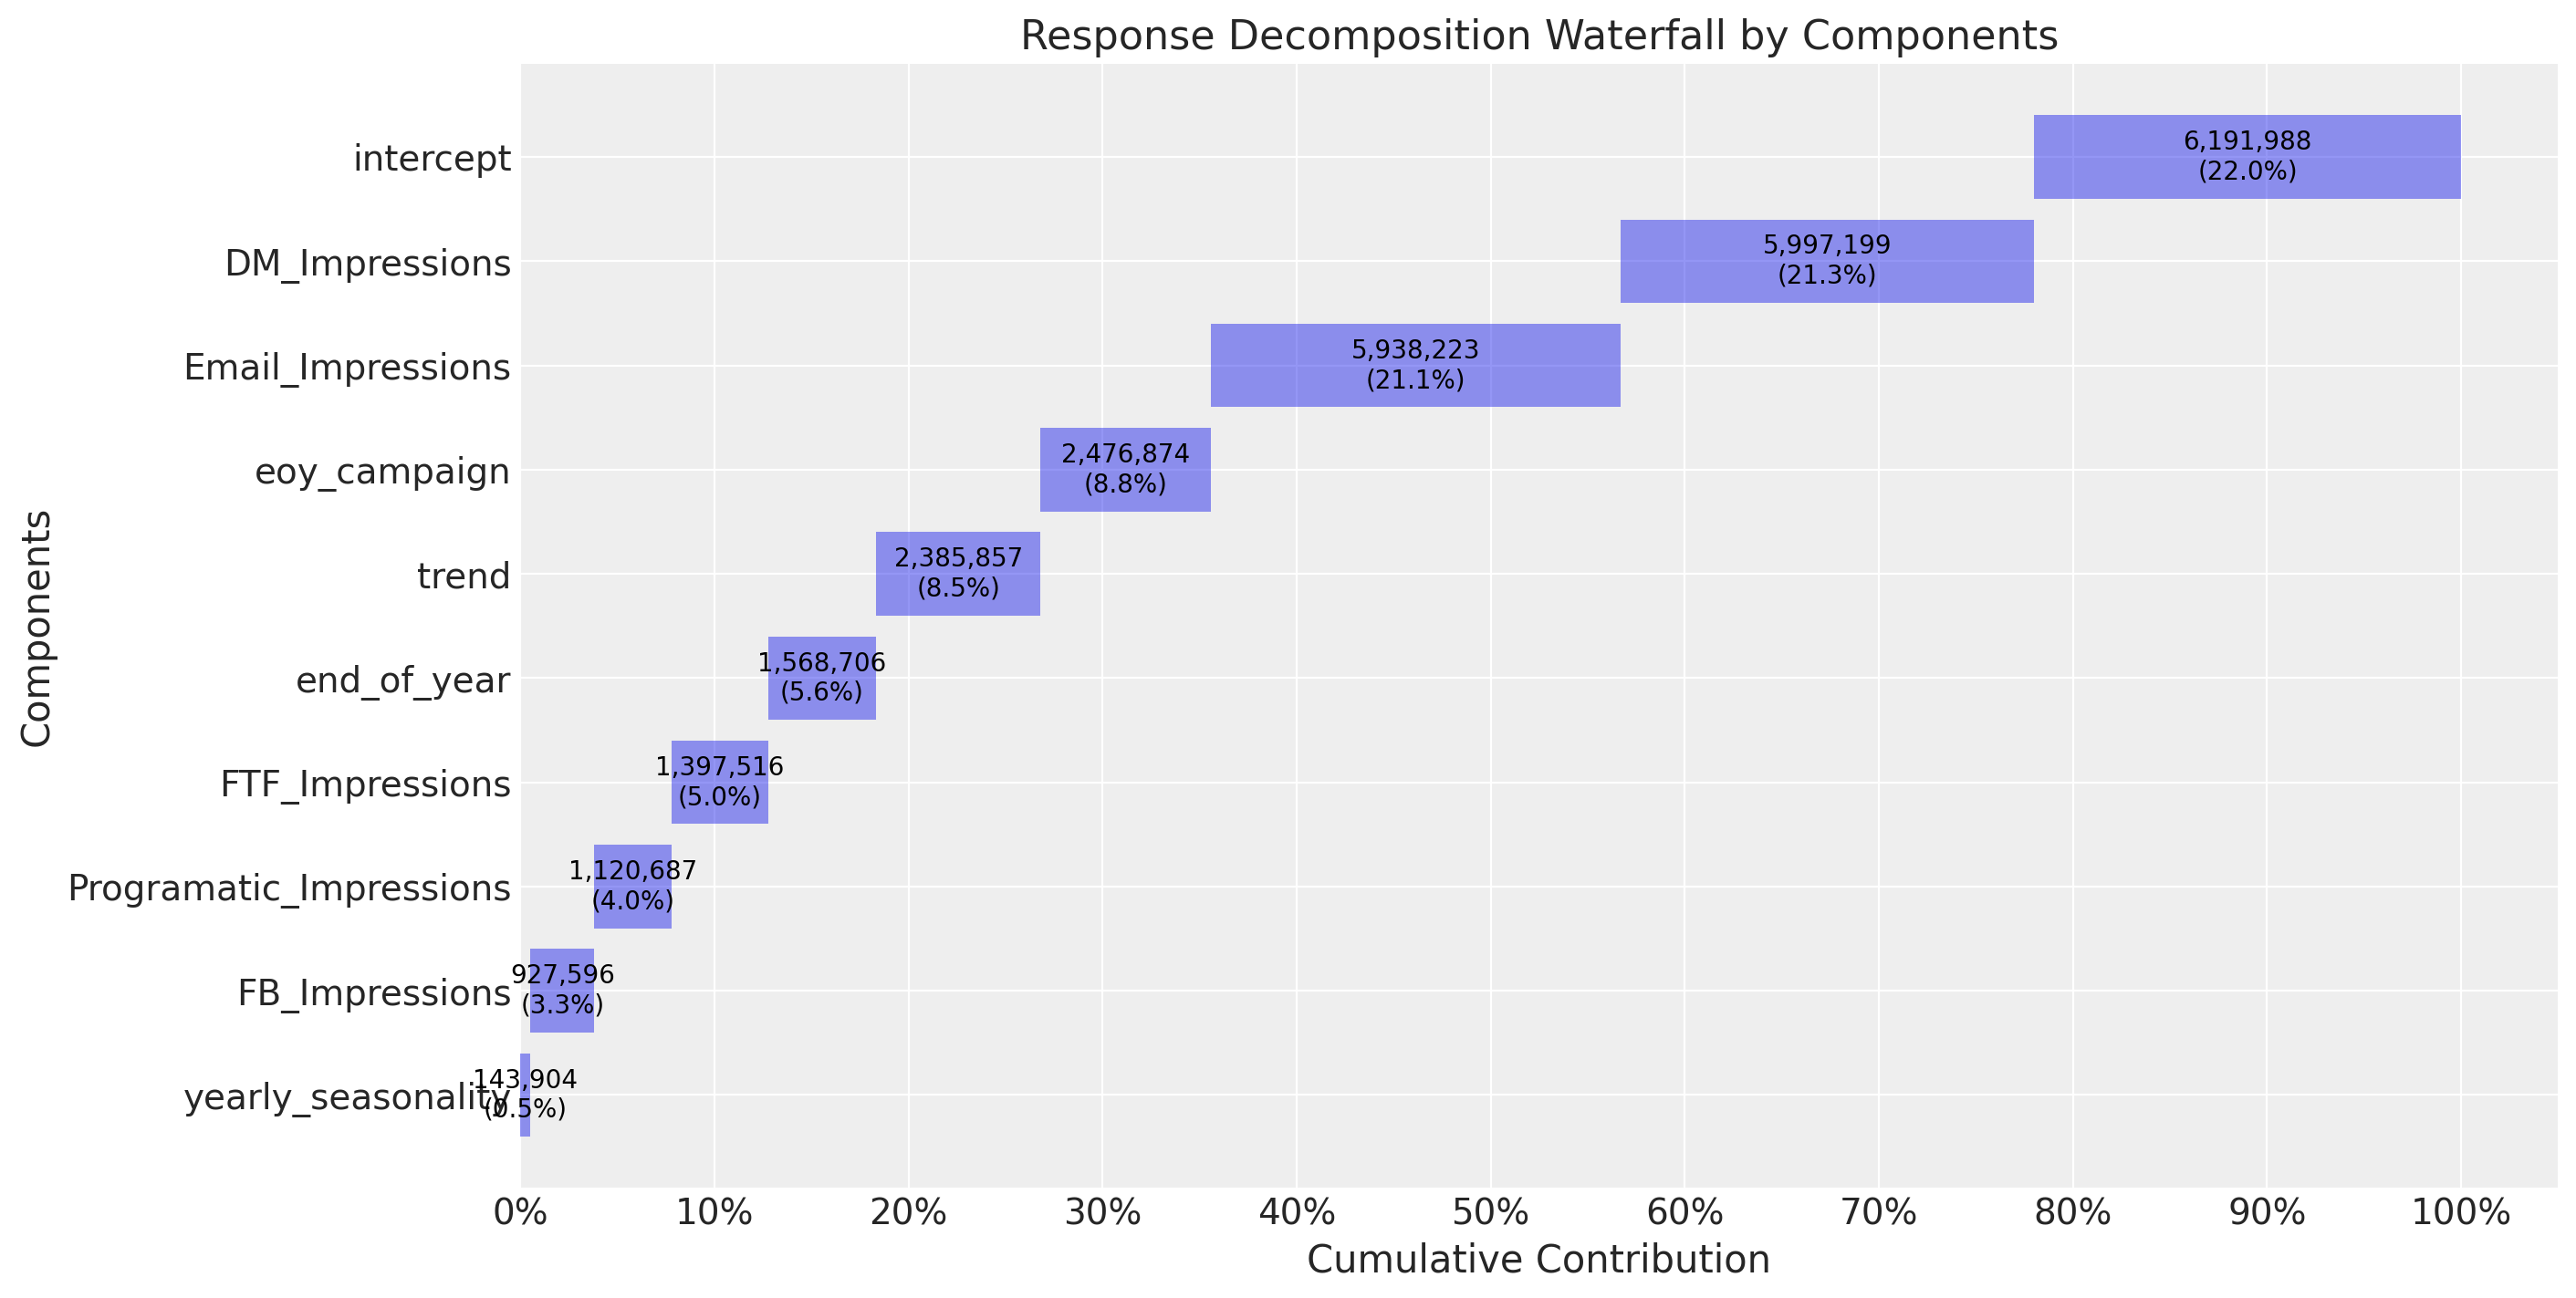

In [89]:
mmm.plot_waterfall_components_decomposition();

In [1]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

NameError: name 'mmm' is not defined

In [ ]:
get_mean_contributions_over_time_df.sum().sum()

In [ ]:
y.sum()

In [ ]:
attr = get_mean_contributions_over_time_df.sum()/get_mean_contributions_over_time_df.sum().sum()*100
attr

In [ ]:
attr.loc[['trend','intercept','yearly_seasonality', 'end_of_year', 'eoy_campaign']].sum()

In [ ]:
X.columns

In [ ]:
mmm.plot_direct_contribution_curves();


In [ ]:


# Step 2: Convert the attribution data to a DataFrame for processing
attr_df = pd.DataFrame(list(attr.items()), columns=['Channel', 'Attribution (%)'])

print(attr_df)


In [ ]:
# Step 3: Dynamically map spend columns to attribution channels based on `data` column names
spend_columns = [col for col in data.columns if '_Spend' in col]
channels = [channel.replace('_Spend', '_Impressions') for channel in spend_columns]
channel_spend_mapping = dict(zip(channels, spend_columns))
attr_df['Spend_Column'] = attr_df['Channel'].map(channel_spend_mapping)

In [ ]:
# Step 4: Add spend data from `data` to the attr_df
attr_df['Spend'] = attr_df['Spend_Column'].apply(
    lambda col: data[col].sum() if pd.notna(col) else 0
)


In [ ]:
# Step 5: Normalize the attribution data to calculate effectiveness
attr_df['Effectiveness'] = attr_df['Attribution (%)'] / attr_df['Attribution (%)'].sum()


In [ ]:
# Step 6: Calculate ROAS (Revenue contribution / Spend)
total_revenue = data['Revenue'].sum()
print(total_revenue)
attr_df['ROAS'] = (attr_df['Attribution (%)'] / 100 * total_revenue) / attr_df['Spend']

In [ ]:
# Sum the spend columns across all rows in spend_df to get total spend for each channel
spend_totals = spend_df[['DM_Spend', 'Email_Spend', 'FB_Spend',
                         'Programatic_Spend', 'FTF_Spend']].sum(axis=0)

# Map the spend totals to the channels in attr_df
spend_mapping = {
    'DM_Impressions': spend_totals['DM_Spend'],
    'Email_Impressions': spend_totals['Email_Spend'],
    'FB_Impressions': spend_totals['FB_Spend'],
    'Programatic_Impressions': spend_totals['Programatic_Spend'],
    'FTF_Impressions': spend_totals['FTF_Spend']
}

# Add spend data to attr_df
attr_df['Spend'] = attr_df['Channel'].map(spend_mapping)

# Recalculate ROAS
attr_df['ROAS'] = (attr_df['Attribution (%)'] / 100 * total_revenue) / attr_df['Spend']

# Display the updated DataFrame
print(attr_df[['Channel', 'Attribution (%)', 'Spend', 'ROAS']])


In [ ]:
# Sum the spend columns across all rows in spend_df to get total spend for each channel
spend_totals = spend_df[['DM_Spend', 'Email_Spend', 'FB_Spend',
                         'Programatic_Spend', 'FTF_Spend']].sum(axis=0)

# Map the spend totals to the channels in attr_df
spend_mapping = {
    'DM_Impressions': spend_totals['DM_Spend'],
    'Email_Impressions': spend_totals['Email_Spend'],
    'FB_Impressions': spend_totals['FB_Spend'],
    'Programatic_Impressions': spend_totals['Programatic_Spend'],
    'FTF_Impressions': spend_totals['FTF_Spend']
}

# Add spend data to attr_df
attr_df['Spend'] = attr_df['Channel'].map(spend_mapping)

# Recalculate ROAS
attr_df['ROAS'] = (attr_df['Attribution (%)'] / 100 * total_revenue) / attr_df['Spend']

# Display the updated DataFrame
print(attr_df[['Channel', 'Attribution (%)', 'Spend', 'ROAS']])


In [ ]:
# Assuming spend_df contains impression data
impression_columns = ['DM_Impressions', 'Email_Impressions', 'FB_Impressions',
                      'Programatic_Impressions', 'FTF_Impressions']

# Sum the impressions for each channel across all rows
impression_totals = data[impression_columns].sum(axis=0)

# Map the impression totals to the channels in attr_df
impression_mapping = {
    'DM_Impressions': impression_totals['DM_Impressions'],
    'Email_Impressions': impression_totals['Email_Impressions'],
    'FB_Impressions': impression_totals['FB_Impressions'],
    'Programatic_Impressions': impression_totals['Programatic_Impressions'],
    'FTF_Impressions': impression_totals['FTF_Impressions']
}

# Add the impression totals to attr_df
attr_df['Impressions'] = attr_df['Channel'].map(impression_mapping)

# Check attr_df with impressions added
print(attr_df[['Channel', 'Attribution (%)', 'Impressions']])


In [ ]:
# Define the spend columns corresponding to the channels
spend_columns = ['DM_Spend', 'Email_Spend', 'FB_Spend',
                 'Programatic_Spend', 'FTF_Spend']

# Sum the spend for each channel across all rows in the data
spend_totals = spend_df[spend_columns].sum(axis=0)

# Map the spend totals to the channels in attr_df
spend_mapping = {
    'DM_Impressions': spend_totals['DM_Spend'],
    'Email_Impressions': spend_totals['Email_Spend'],
    'FB_Impressions': spend_totals['FB_Spend'],
    'Programatic_Impressions': spend_totals['Programatic_Spend'],
    'FTF_Impressions': spend_totals['FTF_Spend']
}

# Add the spend totals to attr_df
attr_df['Spend'] = attr_df['Channel'].map(spend_mapping)

# Check attr_df with spend added
print(attr_df[['Channel', 'Attribution (%)', 'Impressions', 'Spend']])


In [ ]:
# Calculate revenue contribution for each channel
attr_df['Revenue_Contribution'] = (attr_df['Attribution (%)'] / 100) * total_revenue

# Calculate effectiveness: Revenue per 1,000 impressions
attr_df['Effectiveness'] = attr_df['Revenue_Contribution'] / (attr_df['Impressions'] / 1000)

# Check final attr_df with effectiveness added
print(attr_df[['Channel', 'Attribution (%)', 'Impressions', 'Spend', 'Revenue_Contribution', 'Effectiveness']])



In [ ]:
# Calculate revenue contribution for each channel as Total Revenue * Attribution (%)
attr_df['Revenue_Contribution'] = attr_df['Attribution (%)'] / 100 * total_revenue

# Add total revenue explicitly as a constant column
attr_df['Total_Revenue'] = total_revenue

# Calculate effectiveness: Revenue per 1,000 impressions
attr_df['Effectiveness'] = attr_df['Revenue_Contribution'] / (attr_df['Impressions'] / 1000)

# Display the final DataFrame with all metrics
print(attr_df[['Channel', 'Attribution (%)', 'Total_Revenue', 'Impressions',
               'Spend', 'Revenue_Contribution', 'Effectiveness']])


In [ ]:
# Configure pandas to display numbers in fixed-point notation
pd.set_option('display.float_format', '{:.2f}'.format)


# Calculate revenue contribution for each channel as Total Revenue * Attribution (%)
attr_df['Revenue'] = attr_df['Attribution (%)'] / 100 * total_revenue

# Add this revenue explicitly as a column
attr_df['RAOS'] = attr_df['Revenue']/attr_df['Spend']

# Calculate effectiveness: Revenue per 1,000 impressions
attr_df['Effectiveness'] = attr_df['Revenue'] / (attr_df['Impressions'] / 1000)

# Display the final DataFrame with all metrics
print(attr_df[['Channel', 'Attribution (%)', 'Revenue', 'Impressions',
               'Spend', 'ROAS', 'Effectiveness']])
